In [1]:
import sys,os
sys.path=["../external/april/py"]+sys.path
print(sys.path)

import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner

from uncertainties import ufloat
from uncertainties.umath import sqrt
from scipy.optimize import minimize
from scipy.optimize import fsolve

['../external/april/py', '/home/Zhi/QA-sim/notebook', '/usr/lib64/python310.zip', '/usr/lib64/python3.10', '/usr/lib64/python3.10/lib-dynload', '', '/home/Zhi/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/site-packages', '/home/Zhi/QA-sim', '/usr/local/lib/python3.10/site-packages/uncertainties-3.1.7-py3.10.egg', '/usr/local/lib/python3.10/site-packages/corner-2.2.1-py3.10.egg', '/usr/local/lib/python3.10/site-packages/future-0.18.2-py3.10.egg', '/usr/lib64/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages/IPython/extensions', '/home/Zhi/.ipython']


In [2]:
# Create Input data
# Create star pair position placed in the E-W direction. Dec=0

QT = qua.QuaTel(A=10.0, ph=0.0)
BSC = qua.BSC_process("../bsc5.dat")

# Filter out the best star pair to observe at March.
# obs_t corresponds to month of the year.
pos = BSC.BSC_filter(obs_t = 3)
print(f"Current source pair of choice: {pos}")

lam = 0.55*10**(-6)

# Baseline vector in [B_EW,B_NS,L=latitude]
B = [200.,0.,0.71]

# Use some sample star, here I use sample pos[0] as a sample star
T = [-5000,5000]     
source = pos[0]

extra_ra =(source[0,1]+source[1,1])/2
source -= np.array([[0.0,extra_ra+3*np.pi/2,0.0,0.0],[0.0,extra_ra+3*np.pi/2,0.0,0.0]])

print('source after modification: ',source)

boost = 1.0

posNum, t_pos, posPhase = QT.get_num_photon(source,B,lam,T,'pos')
posData = qua.sim_data(posNum[0]*boost, t_pos, posPhase[0],'pos')   
posPhase = None
posNum = None

print('Positive Data Done')

negNum, t_neg, negPhase = QT.get_num_photon(source,B,lam,T,'neg')
negData = qua.sim_data(negNum[0]*boost,t_neg, negPhase[0],'neg')
negPhase = None
negNum = None

print("Negative Data done")

# Find theoretical parameter values and theoretical separation between two sources
theo_par,theo_d = QT.get_theo_par(source)

print("Theoretical separation: ", theo_d)
print("Theoretical Parameter: ", theo_par)

L= qua.sim_like(theo_par, B, source, lam, t_pos = posData.timestamp, t_neg = negData.timestamp)
print("Current likelihood: ", L.loglike_wprior())

Current source pair of choice: [[[5.05500000e+03 3.50785000e+00 9.58563914e-01 9.57417549e+01]
  [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]]
source after modification:  [[ 5.05500000e+03 -4.71235626e+00  9.58563914e-01  9.57417549e+01]
 [ 5.05400000e+03 -4.71242171e+00  9.58626940e-01  4.49884866e+02]]
Positive Data Done
Negative Data done
Theoretical separation:  7.339561468310582e-05
Theoretical Parameter:  [ 1.69154507e-01  3.76120658e-05 -6.30257785e-05  0.00000000e+00]
Current likelihood:  30.311178178361935


[0.00314474]


3

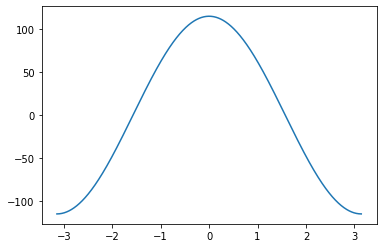

In [14]:
# Prints to see how dot product changes over time.
def dot_(p,source,baseline, latitude = 0.71):
    x = np.cos(source[:,2])*np.cos(source[:,1]-p)
    y = np.cos(source[:,2])*np.sin(source[:,1]-p)
    z = np.sin(source[:,2])
    
    mid_x = (x[0]+x[1])/2
    mid_y = (y[0]+y[1])/2
    mid_z = (z[0]+z[1])/2
    
    dx = x[0]-x[1]
    dy = y[0]-y[1]
    dz = (z[0]-z[1]) - np.sin(latitude)
    
    
    maximum = np.sqrt(dy**2+dx**2+dz**2)*np.sqrt(baseline[0]**2+baseline[1]**2)
    #para = -baseline[1]*np.sin(baseline[2])*dx + baseline[0]*dy + baseline[1]*np.cos(baseline[2])*dz
    ortho = -baseline[1]*np.sin(baseline[2])*mid_x + baseline[0]*mid_y + baseline[1]*np.cos(baseline[2])*mid_z
   
    return ortho
    #return para

x= np.linspace(-np.pi,np.pi,1000)
y = []

for i in x:
    yi = dot_(i,source,B)
    y.append(yi)
    
plt.plot(x,y)
print(x[np.where(y==np.amax(y))])

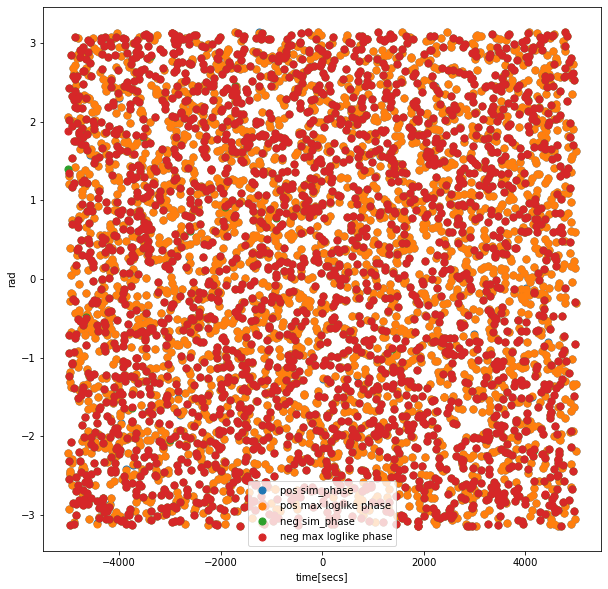

In [3]:
# Theoretical sim_phase data should overlap with pos max loglike data.
plt.figure(figsize=(10,10))

plt.scatter(posData.timestamp[:],np.mod((posData.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'pos sim_phase')
plt.scatter(posData.timestamp[:], np.mod((L.get_phase()[0][:]+ np.pi),2*np.pi) - np.pi, s= 50,label = 'pos max loglike phase')

plt.scatter(negData.timestamp[:],np.mod((negData.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'neg sim_phase')
plt.scatter(negData.timestamp[:], np.mod((L.get_phase()[1][:]+ np.pi),2*np.pi) - np.pi, s= 50,label = 'neg max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')

plt.legend()

In [6]:
# Run the MCMC
MCMCAnalyzer.MCMCAnalyzer(L,"./output_data",temp=2, nsamp=300000)

Bounds: [ 0.00000000e+00  3.76095658e-05 -6.30332785e-05 -3.14159265e+00] [ 1.00000000e+00  3.76145658e-05 -6.30182785e-05  3.14159265e+00]
Starting chain...
Accepted samples 1000 2
Accepted samples 2000 1
Accepted samples 3000 1
Accepted samples 4000 1
Accepted samples 5000 2
Re-initializing covariance matrix after burn-in
[[ 7.25545683e-04 -1.50482503e-12 -7.35003201e-14 -8.36564706e-05]
 [-1.50482503e-12  1.41655921e-19  3.24953768e-20  6.15966478e-11]
 [-7.35003201e-14  3.24953768e-20  2.07150841e-19  3.60584391e-10]
 [-8.36564706e-05  6.15966478e-11  3.60584391e-10  6.62508264e-01]]
V 0.1535358666659149 0.02693595520149998
d_ew 3.761210701426021e-05 3.763720508627398e-10
d_ns -6.30265746293247e-05 4.5513826558712325e-10
offset -1.5940395115142243 0.8139461064362281
New maxloglike 31.008710673522305
New maxloglike 31.736749593463855
New maxloglike 31.763090495067022
New maxloglike 31.76700276205833
Accepted samples 6000 4
New maxloglike 31.813177916242932
Accepted samples 7000 1
Ac

Accepted samples 281000 1
Accepted samples 282000 1
Accepted samples 283000 2
Accepted samples 284000 1
Accepted samples 285000 2
Accepted samples 286000 4
Accepted samples 287000 3
Accepted samples 288000 3
Accepted samples 289000 4
Accepted samples 290000 4
Accepted samples 291000 1
Accepted samples 292000 3
Accepted samples 293000 4
Accepted samples 294000 1
Accepted samples 295000 1
Accepted samples 296000 7
Accepted samples 297000 1
Accepted samples 298000 1
Accepted samples 299000 1
Accepted samples 300000 1


Sigma ew from general formula = 0.07442193348053039
Sigma ns from general formula = 0.12470732991850757
Sigma from MCMC = [0.02958481 0.08230952 0.19019201 1.67310592]


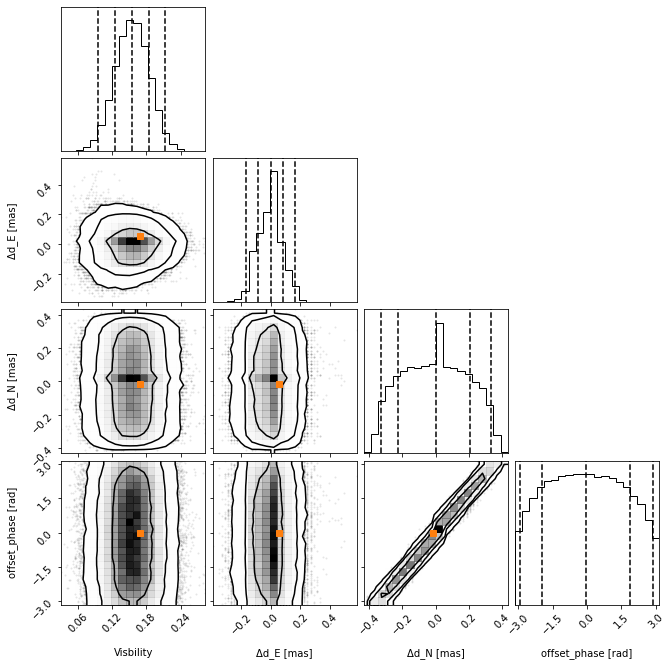

In [11]:
plotting = qua.plot_triangle("./output_data.txt", theo_par, 10000.0, posData.avg_rate, posData.N,)
plotting.plot()

Theoretical parameter:  [ 1.69154507e-01  3.76120658e-05 -6.30257785e-05  0.00000000e+00]
Sigma ew from general formula = 0.03934030351699219
Sigma ns from general formula = 0.06592175156361987
590004
Sigma from MCMC = [0.03110914 0.05705347 0.18858345 1.56749886]


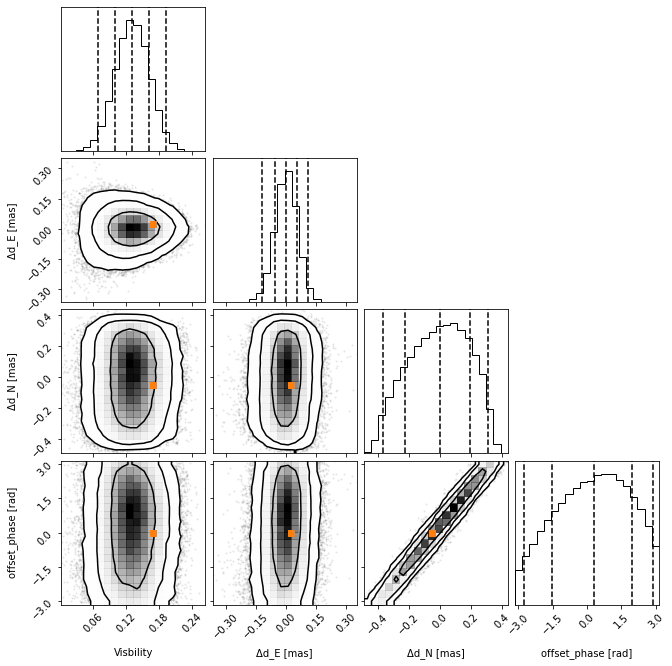

In [8]:
print('Theoretical parameter: ', theo_par)
res = np.loadtxt("../output/output_data.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-posData.V**2))/posData.V**2

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/posData.V/np.sqrt(2*T[1]*posData.avg_rate)*theo_par[1]/posData.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/posData.V/np.sqrt(2*T[1]*posData.avg_rate)*theo_par[2]/posData.N) 
print("Sigma ew from general formula =", theo_sigma_ew/4.8481368e-9/np.sqrt(2.0))
print("Sigma ns from general formula =", theo_sigma_ns/4.8481368e-9/np.sqrt(2.0))

# Find center point of d_ew and d_ns
d_ew_mid = corner.quantile(mcmc_data[:,1],0.5)
d_ns_mid = corner.quantile(mcmc_data[:,2],0.5)

mcmc_data[:,1] = (mcmc_data[:,1] - d_ew_mid)/4.8481368e-9
mcmc_data[:,2] = (mcmc_data[:,2] - d_ns_mid)/4.8481368e-9

theo_par[1] = (theo_par[1] - d_ew_mid)/4.8481368e-9
theo_par[2] = (theo_par[2] - d_ns_mid)/4.8481368e-9

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','Δd_E [mas]','Δd_N [mas]','offset_phase [rad]'],quantiles=(0.023, 0.16, 0.5, 0.84,0.977),levels=(0.68,0.952,0.994))
corner.overplot_points(figure, np.array(list(theo_par))[None], marker="s", color="C1",label="Theo")
figure.savefig('../output/output_data.jpg',facecolor='white')

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)